In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.decomposition import PCA
import os
import requests
from io import BytesIO

THÔNG SỐ ẢNH
Kích thước: 612px x 408px
Số kênh màu: 3


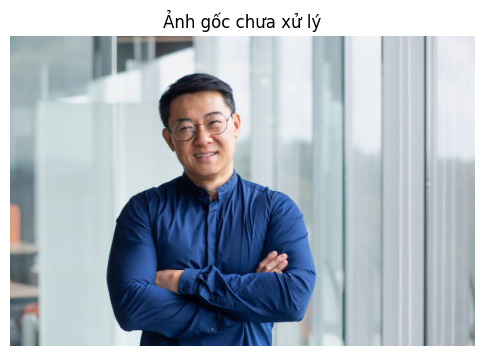

In [11]:
import re

direct_link = 'https://drive.google.com/file/d/1FSzSkvWlI-jmc6mHxDabGHTBxl3R8VL-/view?usp=sharing'

# Extract file ID from the Google Drive link
file_id_match = re.search(r'file/d/([a-zA-Z0-9_-]+)', direct_link)
if file_id_match:
    file_id = file_id_match.group(1)
    download_link = f'https://drive.google.com/uc?export=download&id={file_id}'
else:
    raise ValueError("Could not extract file ID from the Google Drive link.")

response = requests.get(download_link)
file_path = '/content/ASIAMAN.png'

# Ensure the request was successful before trying to open the image
if response.status_code == 200:
    img = Image.open(BytesIO(response.content))
    img_np = np.array(img)

    # Lấy thông số ảnh
    height, width, channels = img_np.shape
    # os.path.getsize(file_path) will not work here since we are loading from memory
    # We can estimate size or skip for now if not critical
    # For now, let's remove original_size calculation as it refers to a local file that might not exist yet
    # original_size = os.path.getsize(file_path) / 1024 # Đổi sang KB

    print(f"THÔNG SỐ ẢNH")
    print(f"Kích thước: {width}px x {height}px")
    print(f"Số kênh màu: {channels}")
    # print(f"Dung lượng file: {original_size:.2f} KB") # Removed

    # Hiển thị ảnh gốc
    plt.figure(figsize=(6, 6))
    plt.imshow(img_np)
    plt.title("Ảnh gốc chưa xử lý")
    plt.axis('off')
    plt.show()
else:
    print(f"Failed to download image. Status code: {response.status_code}")
    print(f"Response content: {response.text[:200]}...") # Print first 200 chars of content for debugging

In [12]:
def process_pca_compression(image_np, k):
    # Các pixel ảnh gốc có giá trị từ 0 đến 255 nên chia 255 để chuẩn hóa ảnh về khoảng [0, 1]
    img_scaled = image_np / 255.0

    # Tách 3 kênh màu
    channels = [img_scaled[:,:,i] for i in range(3)]

    reconstructed_channels = []
    pca = PCA(n_components=k)

    for ch in channels:
        #Nén ảnh
        compressed_data = pca.fit_transform(ch)

        #Giải nén
        reconstructed_data = pca.inverse_transform(compressed_data)
        reconstructed_channels.append(reconstructed_data)

    #Gộp lại thành ảnh RGB
    img_reconstructed = np.stack(reconstructed_channels, axis=2)
    img_reconstructed = np.clip(img_reconstructed, 0, 1)

    #Tính toán tỉ lệ dữ liệu được giữ lại
    ratio = (k * (height + width)) / (height * width) * 100
    return img_reconstructed, ratio

k_list = [5, 25, 50, 75, 100]
results = []

for k in k_list:
    reconstructed_img, storage_ratio = process_pca_compression(img_np, k)
    results.append((k, reconstructed_img, storage_ratio))
    print(f"Đã xử lý xong K = {k:3d} | Dữ liệu giữ lại: ~{storage_ratio:.2f}%")

Đã xử lý xong K =   5 | Dữ liệu giữ lại: ~2.04%
Đã xử lý xong K =  25 | Dữ liệu giữ lại: ~10.21%
Đã xử lý xong K =  50 | Dữ liệu giữ lại: ~20.42%
Đã xử lý xong K =  75 | Dữ liệu giữ lại: ~30.64%
Đã xử lý xong K = 100 | Dữ liệu giữ lại: ~40.85%


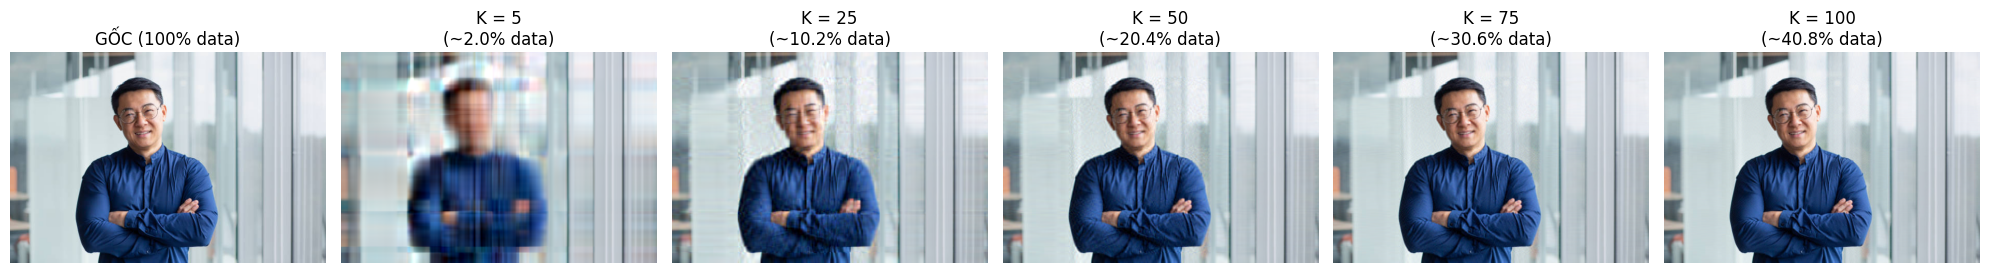

In [13]:
plt.figure(figsize=(20, 10))

#Hiển thị ảnh gốc
plt.subplot(1, len(k_list) + 1, 1)
plt.imshow(img_np)
plt.title("GỐC (100% data)")
plt.axis('off')

#Hiển thị các ảnh đã nén và giải nén qua PCA
for i, (k, res_img, ratio) in enumerate(results):
    plt.subplot(1, len(k_list) + 1, i + 2)
    plt.imshow(res_img)
    plt.title(f"K = {k}\n(~{ratio:.1f}% data)")
    plt.axis('off')

plt.tight_layout()
plt.show()